In [38]:
import pandas as pd
import numpy as np

from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = (18.0, 10.0)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm

In [37]:
ds = pd.read_csv('../data/processed/train_3600000000000.csv', parse_dates=[1])
ds.groupby('SiteId')['SiteId'].first()

SiteId
2        2
16      16
20      20
26      26
27      27
39      39
40      40
42      42
45      45
51      51
53      53
54      54
57      57
60      60
66      66
72      72
73      73
76      76
77      77
85      85
86      86
93      93
96      96
98      98
99      99
100    100
101    101
112    112
117    117
127    127
      ... 
216    216
223    223
224    224
231    231
234    234
236    236
239    239
247    247
250    250
251    251
254    254
259    259
260    260
263    263
264    264
266    266
267    267
268    268
273    273
277    277
278    278
281    281
283    283
285    285
286    286
288    288
292    292
294    294
297    297
300    300
Name: SiteId, Length: 89, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a204c65f8>,
      dtype=object)

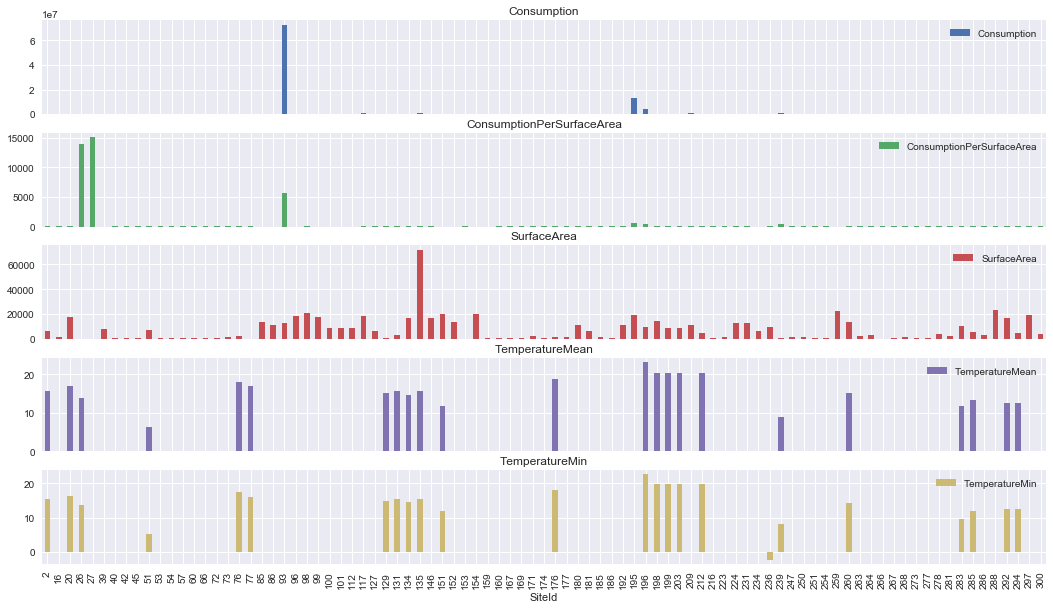

In [39]:
ds.groupby('SiteId')[['Consumption', 'ConsumptionPerSurfaceArea', 'SurfaceArea', 'TemperatureMean', 'TemperatureMin']].mean().plot(subplots=True, kind='bar')


In [40]:
dataset = ds.loc[ds['SiteId'] == 100, :]
dataset.shape

(15424, 59)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a551d64a8>,
      dtype=object)

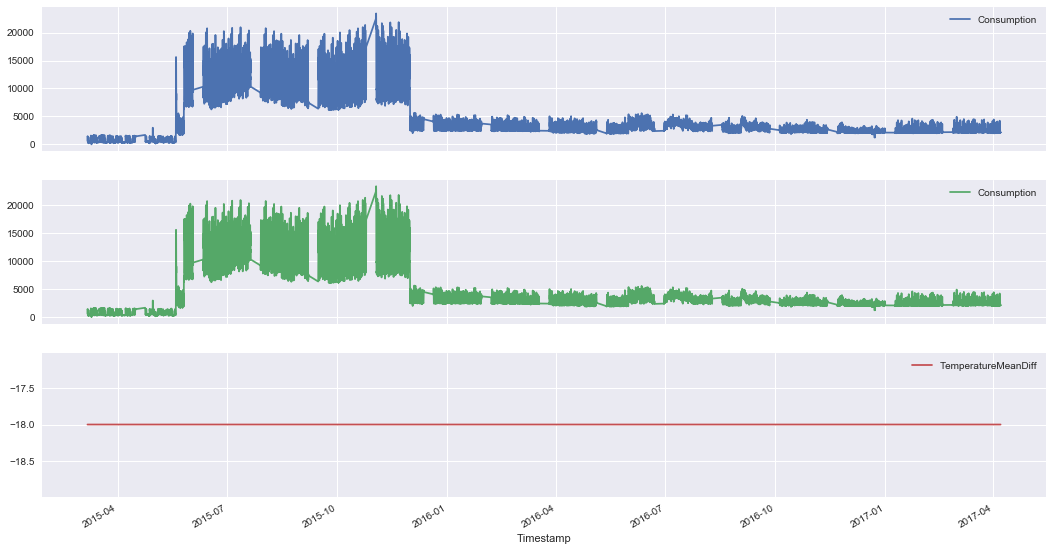

In [41]:
dataset.set_index('Timestamp')[['Consumption', 'Consumption', 'TemperatureMeanDiff']].plot(subplots=True)


In [6]:
dataset.keys()

Index(['ForecastId', 'Timestamp', 'obs_id', 'SiteId', 'Value', 'Frequency',
       'DayOfMonth', 'DayOfWeek', 'DayOfYear', 'DaysInMonth', 'Hour',
       'IsLeapYear', 'IsMonthEnd', 'IsMonthStart', 'IsQuarterEnd',
       'IsQuarterStart', 'IsYearEnd', 'IsYearStart', 'Minute', 'Month',
       'Quarter', 'WeekOfYear', 'DayOfMonth_cos', 'DayOfMonth_sin',
       'DayOfWeek_cos', 'DayOfWeek_sin', 'DaysInYear', 'DayOfYear_cos',
       'DayOfYear_sin', 'Hour_cos', 'Hour_sin', 'Minute_cos', 'Minute_sin',
       'Month_cos', 'Month_sin', 'Quarter_cos', 'Quarter_sin',
       'WeekOfYear_cos', 'WeekOfYear_sin', 'IsSpecialHoliday', 'IsWeekend',
       'IsHoliday', 'DistanceMean', 'DistanceVariance', 'NumStations',
       'TemperatureMean', 'TemperatureVariance', 'TemperatureMin',
       'TemperatureMax', 'HasTemperature', 'SamplingRate', 'BaseTemperature',
       'SurfaceArea', 'TemperatureMeanDiff', 'TemperatureMinDiff',
       'TemperatureMaxDiff', 'Consumption', 'ConsumptionPerSurfaceArea',
    

In [42]:
features = [
    'IsMonthEnd', 'IsQuarterEnd', 'IsQuarterStart', 'IsYearEnd', 'IsYearStart', 'DayOfMonth_cos', 
    'DayOfMonth_sin', 'Quarter_cos', 'Quarter_sin', 'WeekOfYear_cos', 'WeekOfYear_sin', 'Hour_cos', 'Hour_sin',
    'Month_cos', 'Month_sin', 'IsSpecialHoliday', 'IsWeekend',
    'IsHoliday', 'Consumption',
#     'DistanceMean', 'DistanceVariance', 'NumStations', 'TemperatureMeanDiff', 'TemperatureVariance', 
#     'TemperatureMinDiff', 'TemperatureMaxDiff', 'HasTemperature'
]

ts = dataset[features]

In [43]:
ts_x = ts.drop(columns=['Consumption'])
ts_y = ts['Consumption']
ts_fids = dataset['ForecastId']

ts_fids.value_counts()

2039    964
2031    964
2038    964
2030    964
2037    964
2029    964
2036    964
2028    964
2035    964
2027    964
2034    964
2026    964
2041    964
2033    964
2040    964
2032    964
Name: ForecastId, dtype: int64

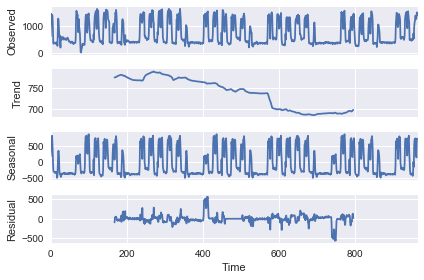

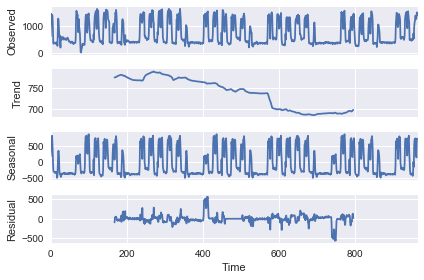

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(ts_y.values[0:964], freq=2*7*24)

decompose.plot()

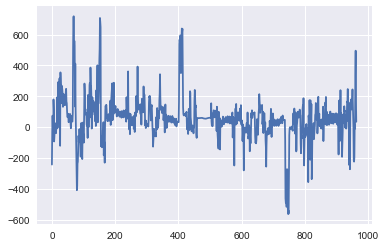

In [30]:
plt.plot(range(decompose.seasonal.shape[0]), ts_y.values[0:964] - (np.nanmin(decompose.trend) + decompose.seasonal))

In [10]:
import math

input_window_size = 240
output_window_size = 192
frequency = np.timedelta64(1, 'h')

In [11]:
def generate_test_train_split(x, y, forecast_ids, input_window_size, output_window_size, test_size=0.2):
    min_test_size = (input_window_size + output_window_size) * 2
    fids, counts = np.unique(forecast_ids, return_counts=True)
    
    num_forecasts_for_test = round(fids.shape[0]*test_size)
    testable_fids = fids[np.where(counts >= min_test_size)]
    
    test_fids = np.random.choice(testable_fids, num_forecasts_for_test)
    
    test_mask = np.repeat([False], forecast_ids.shape[0])
    
    test_size = input_window_size + output_window_size
    for fid in test_fids:
        indices,  = np.where(forecast_ids == fid)
        test_mask[indices[-test_size:]] = True
            
    train_mask = np.logical_not(test_mask)
    
    return x[train_mask], y[train_mask], forecast_ids[train_mask], x[test_mask], y[test_mask], forecast_ids[test_mask]
    
ts_xtrain, ts_ytrain, ts_ftrain, ts_xtest, ts_ytest, ts_ftest = generate_test_train_split(ts_x, ts_y, ts_fids, input_window_size, output_window_size)

print(ts_xtrain.shape, ts_ytrain.shape)
print(ts_xtest.shape, ts_xtest.shape)

(14128, 18) (14128,)
(1296, 18) (1296, 18)


In [12]:
def generate_train_forecast_ts(x, y, input_window_size, output_window_size, pad=True):
    assert x.shape[0] == y.shape[0]
    
    min_size = input_window_size + output_window_size
    input_size = x.shape[0]
    
    if input_size < min_size and pad:
        num_pads = min_size - input_size
        
        x_pad = np.zeros((num_pads, x.shape[1]))
        y_pad = np.zeros((num_pads, y.shape[1]))
        x = np.vstack((x_pad, x))
        y = np.vstack((y_pad, y))
        
    assert x.shape[0] >= min_size
        
    num_samples = x.shape[0] - input_window_size - output_window_size + 1
    
    x_res = []
    y_res = []

    for i in range(num_samples):
        x_t = np.hstack((x[i:i + input_window_size], y[i:i + input_window_size].reshape(-1, 1)))

        x_t_plus_1 = x[i + input_window_size:i + input_window_size + output_window_size]
        y_t_plus_1 = y[i + input_window_size:i + input_window_size + output_window_size]

        x_res.append(np.concatenate((x_t.ravel(), x_t_plus_1.ravel())))
        y_res.append(y_t_plus_1)

    return np.array(x_res), np.array(y_res)


def generate_train_ts(x, y, forecast_ids, input_window_size, output_window_size):
    assert x.shape[0] == y.shape[0]
    assert y.shape[0] == forecast_ids.shape[0]
    
    ids = np.unique(forecast_ids)
    
    agg_x = []
    agg_y = []
    for fid in tqdm(ids):
        fx = x[forecast_ids == fid, :]
        fy = y[forecast_ids == fid, :]
                
        fx_res , fy_res = generate_train_forecast_ts(fx, fy, input_window_size, output_window_size)
        
        agg_x.append(fx_res)
        agg_y.append(fy_res)
        
    agg_x = np.concatenate(agg_x)
    agg_y = np.concatenate(agg_y)
    agg_x = agg_x.reshape((agg_x.shape[0], 1, agg_x.shape[1]))
    agg_y = agg_y.reshape((agg_y.shape[0], 1, agg_y.shape[1]))
    
    return agg_x, agg_y


In [13]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()


tx_train, ty_train = generate_train_ts(
    scaler_x.fit_transform(ts_xtrain.values), 
    scaler_y.fit_transform(ts_ytrain.values.reshape(-1, 1)), 
    ts_ftrain.values, 
    input_window_size, output_window_size
)

tx_test, ty_test = generate_train_ts(
    scaler_x.transform(ts_xtest.values),
    scaler_y.transform(ts_ytest.values.reshape(-1, 1)),
    ts_ftest.values,
    input_window_size, output_window_size
)

/Users/sreejithkrishnanr/Tools/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
100%|██████████| 3/3 [00:00<00:00, 5019.11it/s]


In [14]:
from keras.layers import Dense, LSTM, TimeDistributed, Dropout
from keras.models import Sequential

def build_model(x_train, y_train):
    model = Sequential()
    model.add(LSTM(units=125, return_sequences=True, input_shape=(1, x_train.shape[2])))
    model.add(Dropout(0.5))
    model.add(LSTM(units=125, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(units=y_train.shape[2], activation='linear')))
    model.compile(loss='mse', optimizer='adam')

    return model

model = build_model(tx_train, ty_train)

/Users/sreejithkrishnanr/Tools/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
model.fit(tx_train, ty_train, validation_data=(tx_test, ty_test), epochs=40)

Train on 7232 samples, validate on 3 samples
Epoch 1/40
7232/7232 [==============================] - 23s 3ms/step - loss: 0.3407 - val_loss: 2.1362
Epoch 2/40
7232/7232 [==============================] - 21s 3ms/step - loss: 0.2199 - val_loss: 2.0200
Epoch 3/40
7232/7232 [==============================] - 21s 3ms/step - loss: 0.1683 - val_loss: 2.0106
Epoch 4/40
7232/7232 [==============================] - 20s 3ms/step - loss: 0.1468 - val_loss: 1.7729
Epoch 5/40
7232/7232 [==============================] - 21s 3ms/step - loss: 0.1354 - val_loss: 1.7268
Epoch 6/40
7232/7232 [==============================] - 22s 3ms/step - loss: 0.1262 - val_loss: 1.9392
Epoch 7/40
7232/7232 [==============================] - 22s 3ms/step - loss: 0.1241 - val_loss: 1.8418
Epoch 8/40
7232/7232 [==============================] - 22s 3ms/step - loss: 0.1217 - val_loss: 1.8958
Epoch 9/40
7232/7232 [==============================] - 22s 3ms/step - loss: 0.1169 - val_loss: 1.8066
Epoch 10/40
7232/7232 [=====

KeyboardInterrupt: 

In [37]:
def _nwrmse(y_truth, y_pred, scaler_y):
    errors = []

    for i in range(y_truth.shape[0]):
        forecast_y_pred = scaler_y.inverse_transform(y_pred[i, :].ravel())
        forecast_y_truth = scaler_y.inverse_transform(y_truth[i, :].ravel())
        count = forecast_y_pred.shape[0]
        weights = (3 * count - 2 * np.arange(1, count + 1) + 1) / (2 * count ** 2)
        error = np.sqrt(np.sum(((forecast_y_truth - forecast_y_pred) ** 2) * weights))
        mean_error = error / np.average(forecast_y_truth)
        errors.append(mean_error)

    return np.average(errors)

y_pred = model.predict(tx_test)
_nwrmse(ty_test, y_pred, scaler_y)

0.25740300287416656

(192,)
(3, 1, 192)


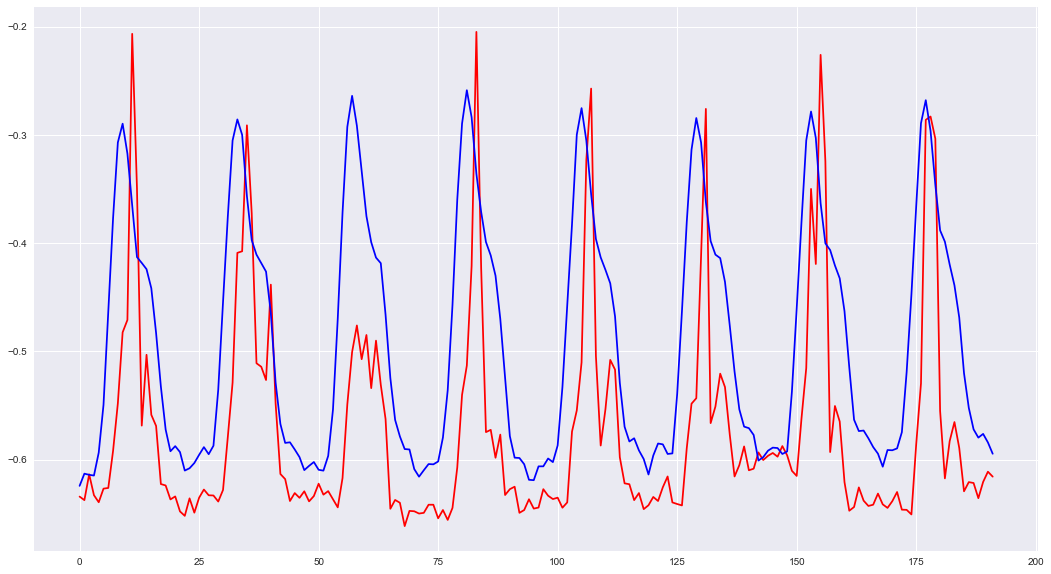

In [38]:
y_p = y_pred[-1, 0]
print(y_p.shape)
print(ty_test.shape)

plt.plot(np.arange(y_p.shape[0]), ty_test[-1, 0].ravel(), color='red')
plt.plot(np.arange(y_p.shape[0]), y_p, color='blue')

In [26]:
tds = pd.read_csv('../data/processed/test_3600000000000.csv', parse_dates=[2])

In [30]:
(tds.groupby('ForecastId')['Timestamp'].max()-tds.groupby('ForecastId')['Timestamp'].min()).min()

Timedelta('7 days 22:00:00')